[View in Colaboratory](https://colab.research.google.com/github/NicolasMauge/Pytorch_Projects/blob/master/Training_93p_43min_K80.ipynb)

In [2]:
!git clone https://github.com/NicolasMauge/Utils
!git clone https://github.com/NicolasMauge/Pytorch_Projects
!. Utils/colab_init.sh
import sys
sys.path.append('Utils')
import colab_utils as utils

sys.path.append('Pytorch_Projects')
import schedulers as sch

Cloning into 'Utils'...
remote: Counting objects: 66, done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 66 (delta 18), reused 55 (delta 14), pack-reused 0
Unpacking objects: 100% (66/66), done.
Cloning into 'Pytorch_Projects'...
remote: Counting objects: 53, done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 53 (delta 20), reused 42 (delta 12), pack-reused 0
Unpacking objects: 100% (53/53), done.
Install of the PyTorch packages
tcmalloc: large alloc 1073750016 bytes == 0x59eb6000 @  0x7f08618e11c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
Install of the PyDrive package
Install of the kaggle package


In [3]:
#!cd Pytorch_Projects && git fetch --all && git reset --hard origin/master
#import schedulers as sch

Fetching origin
HEAD is now at e8e7fc7 import scheduler


# Import of the libraries

In [0]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torchvision.models.resnet import resnet18

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

from torch.nn import functional as F

from PIL import Image

# Definition of the model

## Model

In [0]:
import models.preact_resnet2 as resnet18_pre
import models.wideresnet as wide
from train import BasicModel

In [0]:
def init_resnet18():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = resnet18_pre.ResNet18().to(device).half()

    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    
    return model

In [8]:
# test to verify that the model can work with cifar10
y = init_resnet18()(torch.randn(100,3,32,32))
print(y.size())

# expected "torch.Size([100, 10])"

torch.Size([100, 10])


# Definition of the parameters and load of the data

In [0]:
# from https://github.com/bkj/basenet/blob/master/examples/cifar/cifar10.py
def ReflectionPadding(margin=(4, 4)):
    
    def _reflection_padding(x):
        x = np.asarray(x)
        if len(x.shape) == 2:
            x = np.pad(x, [(margin[0], margin[0]), (margin[1], margin[1])], mode='reflect')
        elif len(x.shape) == 3:
            x = np.pad(x, [(margin[0], margin[0]), (margin[1], margin[1]), (0, 0)], mode='reflect')
        
        return Image.fromarray(x)
    
    return transforms.Lambda(_reflection_padding)

In [10]:
batch_size = 128   

transform_train = transforms.Compose([
    ReflectionPadding(margin=(4, 4)),
    transforms.RandomCrop(32),
    transforms.ColorJitter(.25,.25,.25),
    transforms.RandomRotation(2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
])
# --> the minimal transform_train is 
# transform_train = transforms.Compose([
#     transforms.ToTensor()
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False, num_workers=4)

Files already downloaded and verified


# Schedulers

## Some definitions

In [0]:
def plot_lr(clr, nb_iter):
    test = [clr(n_iter) for n_iter in range(0, nb_iter)]

    plt.plot(range(0,nb_iter), test, color = "red")
    plt.xlabel("Step")
    plt.ylabel("Learning rate")
    plt.title("Lr triangle")
    plt.grid(True,which="both")
    plt.show()

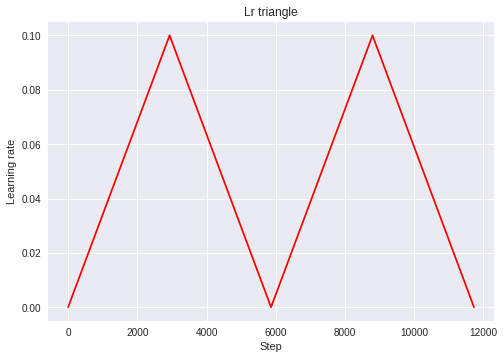

In [60]:
clr = sch.CyclicLR(base_lr=0.0001, max_lr=0.1, iter_by_epoch=391, cycle_len=15)
plot_lr(clr, 391*30)

# Training

In [0]:
base_lr=0.01
#wd = 4e-4
wd = 1e-4

error = nn.CrossEntropyLoss()
model_class = BasicModel(init_resnet18(), train_loader, test_loader, error, weight_decay=wd)

In [0]:
#warm up
%time model_class.train(1, cycle_len=1, lr=0.1)
model_class.lr_find([0.0001, 5], cycle_len=1)
model_class = BasicModel(init_resnet18(), train_loader, test_loader, error, weight_decay=wd)

In [46]:
clr = sch.CyclicLR(base_lr=0.0001, max_lr=0.2, iter_by_epoch=len(train_loader), cycle_len=30)
%time model_class.train(1, cycle_len=30, sched_lr=clr)

Epochs: 0 Cycle: 0 Iter: 391  Tr Loss: 0.01493515625  Tr Acc: 29 Test Acc: 43.03 Last lr: 0.013392583120204611
Epochs: 1 Cycle: 0 Iter: 782  Tr Loss: 0.01026451171875  Tr Acc: 51 Test Acc: 60.71 Last lr: 0.026719249786871277
Epochs: 2 Cycle: 0 Iter: 1173  Tr Loss: 0.00790197265625  Tr Acc: 63 Test Acc: 68.76 Last lr: 0.040045916453537944
Epochs: 3 Cycle: 0 Iter: 1564  Tr Loss: 0.006387890625  Tr Acc: 71 Test Acc: 71.9 Last lr: 0.05337258312020461
Epochs: 4 Cycle: 0 Iter: 1955  Tr Loss: 0.005584013671875  Tr Acc: 75 Test Acc: 77.65 Last lr: 0.06669924978687128
Epochs: 5 Cycle: 0 Iter: 2346  Tr Loss: 0.0049845556640625  Tr Acc: 78 Test Acc: 74.62 Last lr: 0.08002591645353795
Epochs: 6 Cycle: 0 Iter: 2737  Tr Loss: 0.0045769580078125  Tr Acc: 80 Test Acc: 78.61 Last lr: 0.0933525831202046
Epochs: 7 Cycle: 0 Iter: 3128  Tr Loss: 0.0042124658203125  Tr Acc: 81 Test Acc: 81.08 Last lr: 0.10667924978687132
Epochs: 8 Cycle: 0 Iter: 3519  Tr Loss: 0.003913671875  Tr Acc: 82 Test Acc: 80.76 Last

In [32]:
model_class.save_model("cifar10_2018-08-22.pth", to_google_drive=True)

title: cifar10_2018-08-22.pth, mimeType: application/octet-stream
